# Hotel Cancellation Case Study

## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import data

past_data=pd.read_csv(r'INNHotelsGroup_pastdata.csv')
past_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN


In [5]:
new_data=pd.read_csv(r'INNHotelsGroup_newdata.csv')
new_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled
2,INNHG_128129,43,Online,1,126.9,2,1,2022-07-01,1,2,Not Canceled


#### Lets understand exactly how any bookings were cancelled and rebooked in last minute from jan 2021 to june 2022

In [6]:
# lets see how many bookings were cancelled at last moment.

(past_data['booking_status'].value_counts(normalize=True)*100)

booking_status
Not Canceled    67.308899
Canceled        32.691101
Name: proportion, dtype: float64

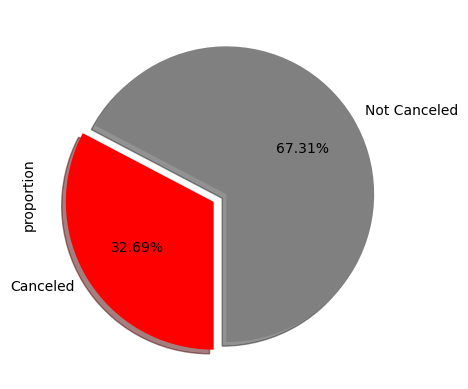

In [7]:
(past_data['booking_status'].value_counts(normalize=True)*100).plot(kind='pie',colors=['grey','red'],\
                                                                    autopct='%.2f%%',startangle=-90,explode=[0,0.1],shadow=True)
plt.show()

In [8]:
# lets see how many canceled booking were rebooked

past_data[past_data['booking_status']=='Canceled']['rebooked'].value_counts(normalize=True)*100

rebooked
No     80.072259
Yes    19.927741
Name: proportion, dtype: float64

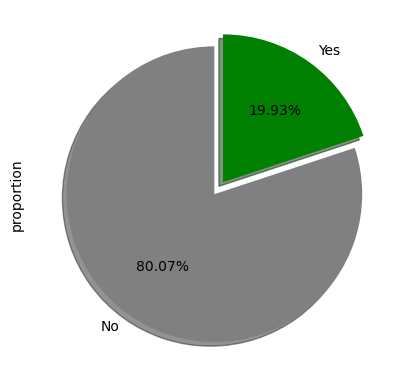

In [9]:
(past_data[past_data['booking_status']=='Canceled']['rebooked'].value_counts(normalize=True)*100).plot(kind='pie',colors=['grey','green'],\
                                                                    autopct='%.2f%%',startangle=90,explode=[0,0.1],shadow=True)
plt.show()

- Inference : Here we can see that out of all the bookings ~30% are being cancelled at last moment and out of all those cancelled bookings only ~20% were rebooked. Which leads to huge inventory loss.

In [10]:
# we can also make booking id as index column as these are just unique identifiers of bookings (rows)
past_data.set_index(past_data['booking_id'],inplace=True)
past_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
booking_id,,,,,,,,,,,,
INNHG_101034,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
INNHG_101035,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
INNHG_101036,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN


In [11]:
past_data.drop(columns='booking_id',inplace=True)

In [12]:
# we can remove the 'rebooked' from data as this information will not be available beforehand.

past_data.drop(columns='rebooked',inplace=True)

In [13]:
past_data.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled
INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled


In [14]:
new_data.set_index(new_data['booking_id'],inplace=True)
new_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,,
INNHG_128127,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
INNHG_128128,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled
INNHG_128129,INNHG_128129,43,Online,1,126.9,2,1,2022-07-01,1,2,Not Canceled


In [15]:
new_data.drop(columns='booking_id',inplace=True)

### Explore the data

In [16]:
print(f'number of rows : {past_data.shape[0]}\nnumber of columns : {past_data.shape[1]}')

number of rows : 27093
number of columns : 10


In [17]:
# check the balance of the target variable
past_data['booking_status'].value_counts(normalize=True)*100

booking_status
Not Canceled    67.308899
Canceled        32.691101
Name: proportion, dtype: float64

In [18]:
# 5 point summary
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [19]:
past_data.select_dtypes(object).describe().T

,count,unique,top,freq
market_segment_type,27093,2,Online,18456
arrival_date,27093,439,2021-03-19,279
booking_status,27093,2,Not Canceled,18236


In [20]:
past_data.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')

In [21]:
# explore the columns one by one 
num_cols=['lead_time', 'avg_price_per_room','no_of_week_nights']
cat_cols=['market_segment_type', 'no_of_special_requests', 'no_of_adults', 
          'no_of_weekend_nights','required_car_parking_space','booking_status']

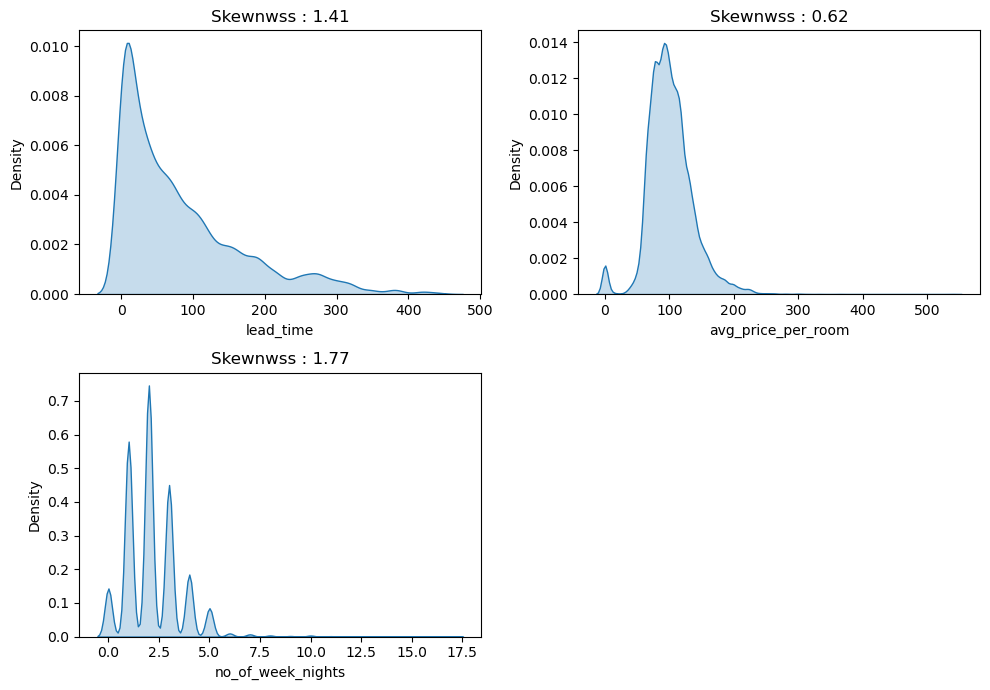

In [22]:
# univariate analysis
t=1
rows=2
cols=2
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(rows,cols,t)
    plt.title(f'Skewnwss : {round(past_data[i].skew(),2)}')
    sns.kdeplot(data=past_data,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()

Inferences :
* lead time is exceeding 300 days! are there bookings which have been made 1 year prior ?
* there are bookings with average price per rooms 0.
* there are customers with very long stays upto 17 week nights.
* What does 0 week night stay means?

In [23]:
past_data[past_data['avg_price_per_room']==0]

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101089,9,Online,2,0.0,2,1,2021-01-01,0,0,Not Canceled
INNHG_101119,24,Online,1,0.0,2,1,2021-01-01,0,0,Not Canceled
INNHG_101140,145,Online,1,0.0,2,0,2021-01-05,0,0,Not Canceled
INNHG_101150,4,Online,1,0.0,1,0,2021-01-05,0,1,Not Canceled
INNHG_101179,145,Online,1,0.0,2,0,2021-01-05,0,0,Not Canceled
...,...,...,...,...,...,...,...,...,...,...
INNHG_127432,3,Online,0,0.0,2,0,2022-06-24,0,0,Not Canceled
INNHG_127463,0,Online,0,0.0,1,0,2022-06-24,0,2,Not Canceled
INNHG_127773,3,Online,0,0.0,1,1,2022-06-27,0,0,Not Canceled


Inferences :
- there is some anamoly in the data where booking is not canceled and avergae price is also 0.

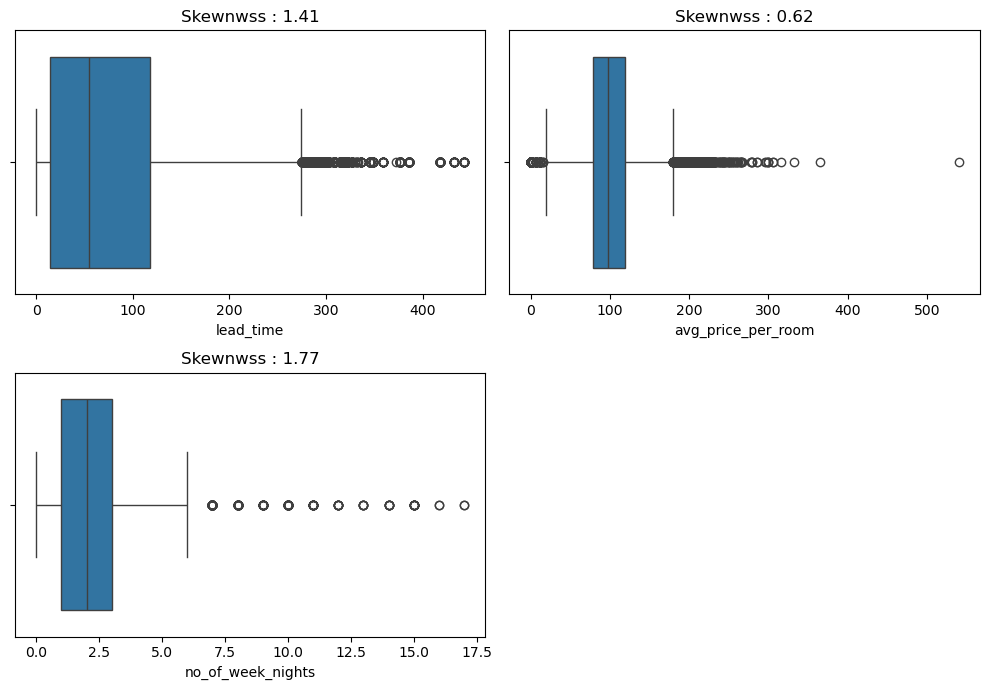

In [24]:
# univariate analysis of outliers 
t=1
rows=2
cols=2
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(rows,cols,t)
    plt.title(f'Skewnwss : {round(past_data[i].skew(),2)}')
    sns.boxplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

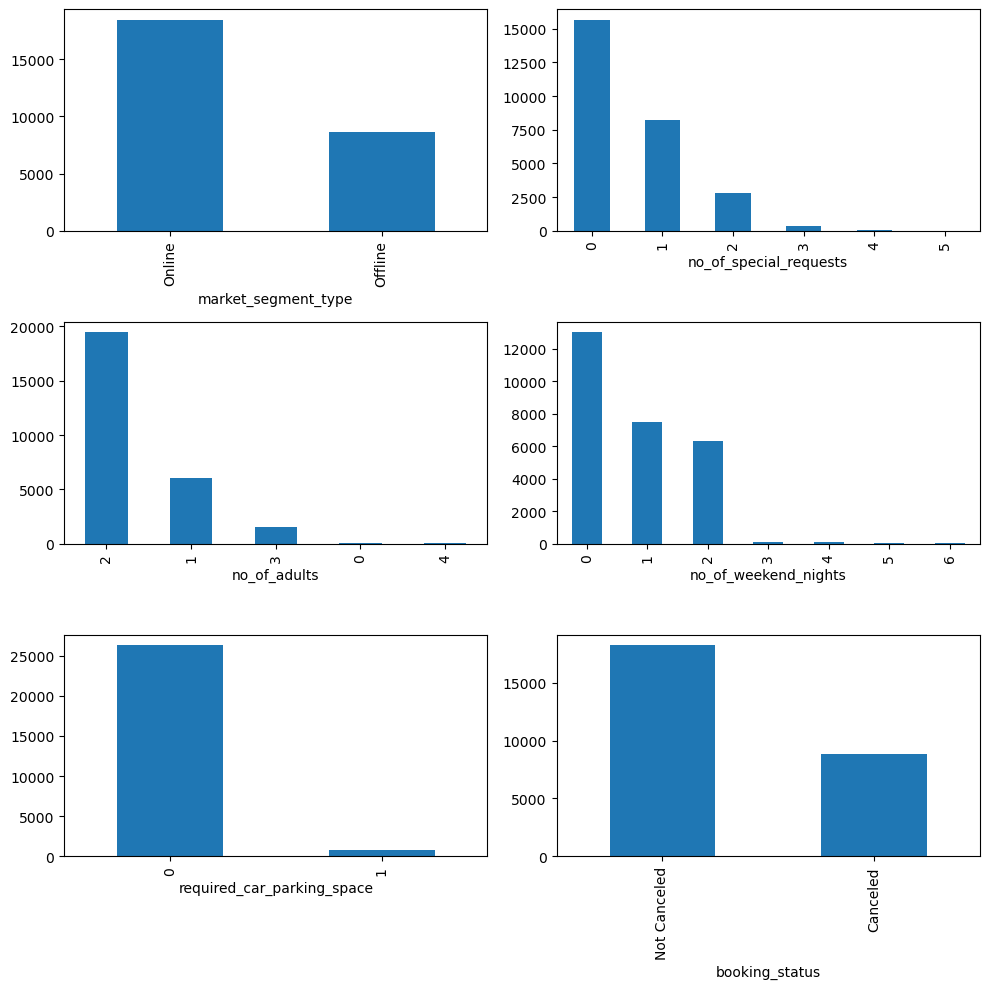

In [25]:
# exploring cat_cols
t=1
rows=3
cols=2
plt.figure(figsize=(10,10))
for i in cat_cols:
    plt.subplot(rows,cols,t)
    past_data[i].value_counts().plot(kind='bar')
    t+=1
plt.tight_layout()
plt.show()

Inferences:
- Most of the bookings have been made online 
- Mostly there are no or 1 sp. request
- In most of the bookings the numbers of adults are 1 or 2
- In most of the bookings max weekend nights are 2
- In most of the bookings do not require parking space

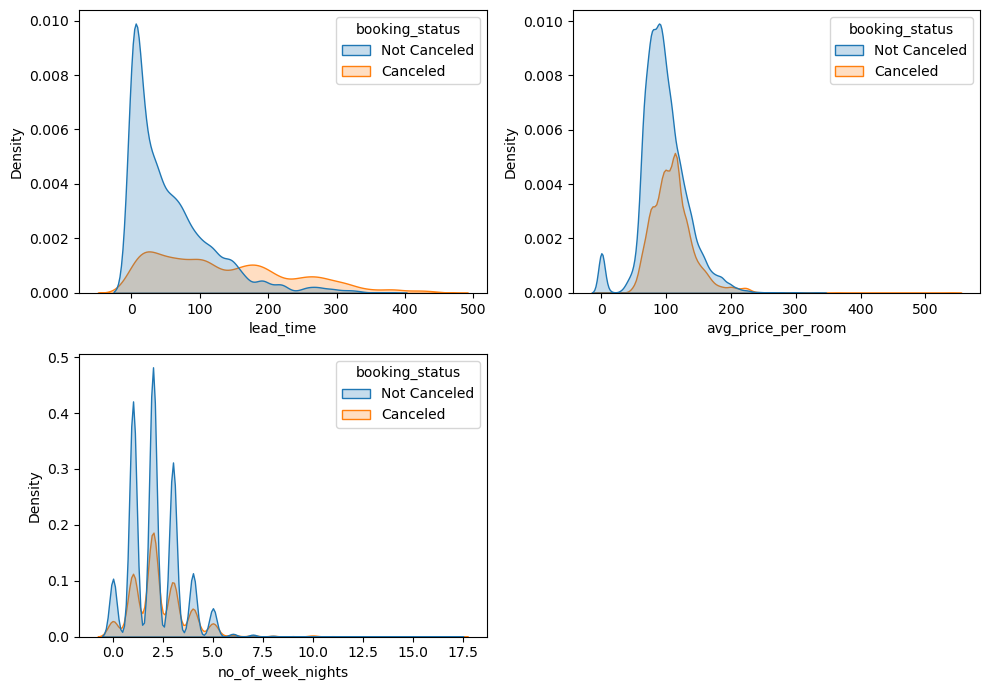

In [26]:
# Bi-variate analysis

t=1
rows=2
cols=2
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(rows,cols,t)
    sns.kdeplot(data=past_data,x=i,hue='booking_status',fill=True)
    t+=1
plt.tight_layout()
plt.show()

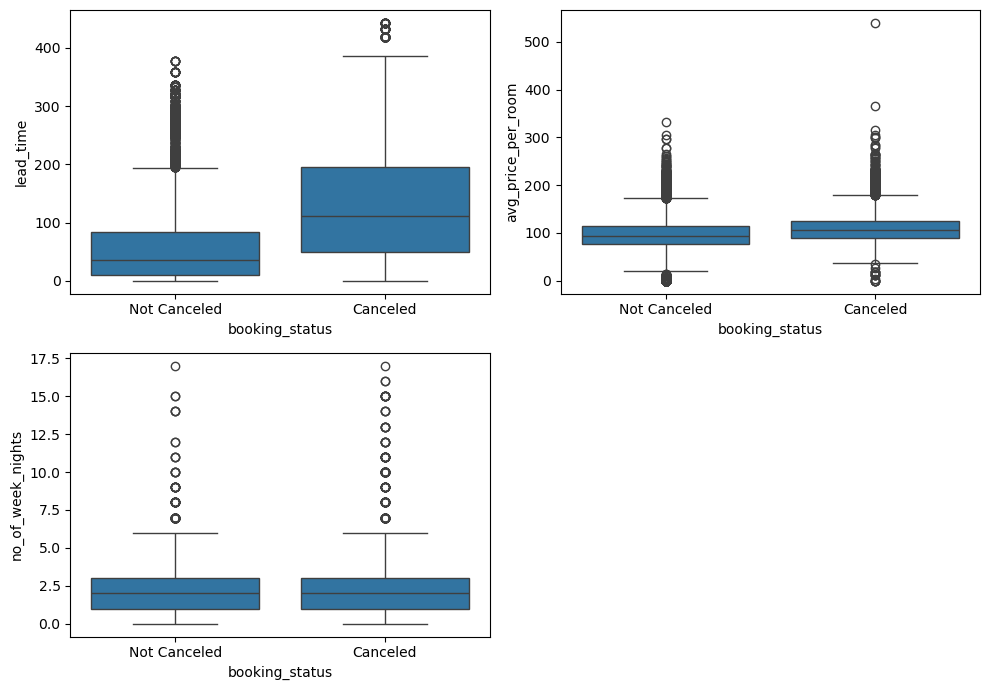

In [27]:
t=1
rows=2
cols=2
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(rows,cols,t)
    sns.boxplot(data=past_data,y=i,x='booking_status')
    t+=1
plt.tight_layout()
plt.show()

Inferences :
- average lead_time for canceled booking is more than not_canceled 
- average price of canceled is more than not_canceled

In [28]:
# lets investigate Lead_time and avg_price_of_rooms with  booking_status
past_data.groupby(by='booking_status')['lead_time'].mean()

booking_status
Canceled        134.035791
Not Canceled     56.140382
Name: lead_time, dtype: float64

In [29]:
samp1=past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2=past_data[past_data['booking_status']=='Not Canceled']['lead_time']

In [30]:
# we will go with 2 sample t-test
# assump1 : data must be normal 
print(stats.shapiro(samp1))
print(stats.shapiro(samp2))

# assump2 : variances are equal
print(stats.levene(samp1,samp2))

# data is not normal and variances are not equal

ShapiroResult(statistic=0.9387743609879114, pvalue=4.865435517353332e-51)
ShapiroResult(statistic=0.8214888949700189, pvalue=7.235137959871973e-88)
LeveneResult(statistic=3210.120590252021, pvalue=0.0)


In [31]:
# lets go with non-parametric test (Mann-Whitneyu test)
# in this we have pass ho

p_value=stats.mannwhitneyu(samp1,samp2,alternative='greater')[1]

if p_value<0.5:
    print('reject null hypothesis')
else:
    print('fail to reject null hypothesis')

# with the cofidence level of 95% we can say that avg_lead_time of canceled bookings are greater than not canceled bookings.

reject null hypothesis


In [32]:
past_data.groupby(by='booking_status')['avg_price_per_room'].mean()

booking_status
Canceled        109.722152
Not Canceled     96.802253
Name: avg_price_per_room, dtype: float64

In [33]:
samp1=past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2=past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']

In [34]:
# we will go with 2 sample t-test
# assump1 : data must be normal 
print(stats.shapiro(samp1))
print(stats.shapiro(samp2))

# assump2 : variances are equal
print(stats.levene(samp1,samp2))

# data is not normal and variances are not equal

ShapiroResult(statistic=0.9253871055438694, pvalue=1.5094155400796404e-54)
ShapiroResult(statistic=0.9534249109201302, pvalue=3.2212372568679052e-59)
LeveneResult(statistic=29.227364523829735, pvalue=6.490728476679038e-08)


In [35]:
# lets go with non-parametric test (Mann-Whitneyu test)
# in this we have pass ho

p_value=stats.mannwhitneyu(samp1,samp2,alternative='greater')[1]

if p_value<0.5:
    print('reject null hypothesis')
else:
    print('fail to reject null hypothesis')

# with the cofidence level of 95% we can say that avg_price_per_room of canceled bookings are greater than not canceled bookings.

reject null hypothesis


<Figure size 1000x1000 with 0 Axes>

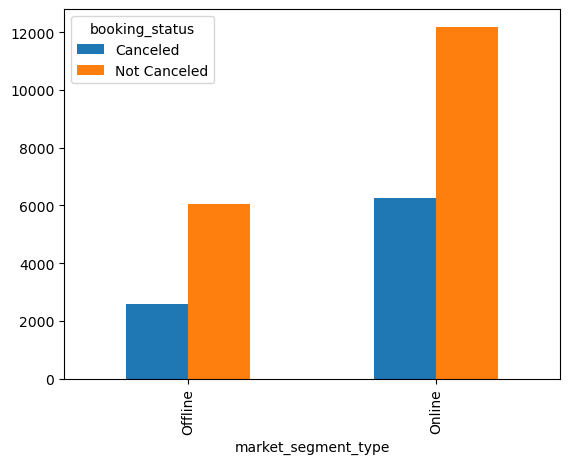

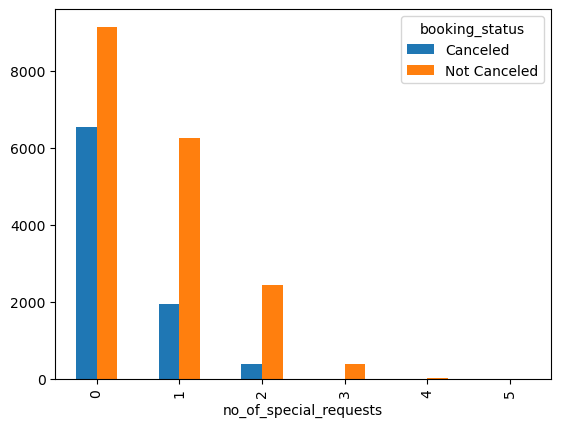

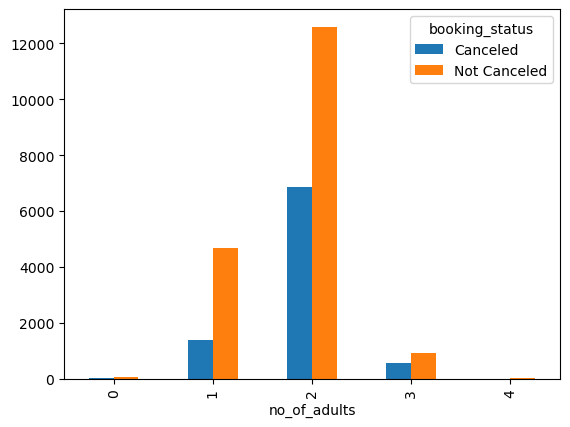

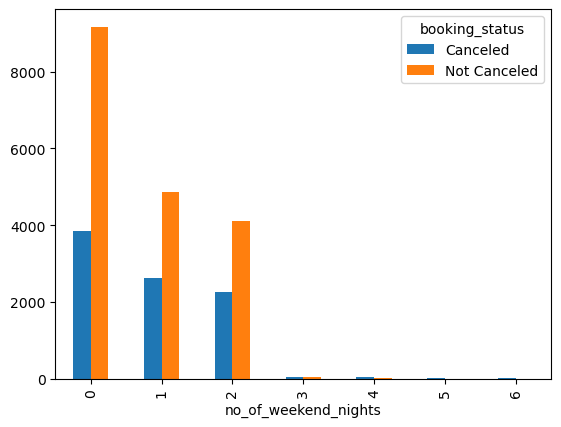

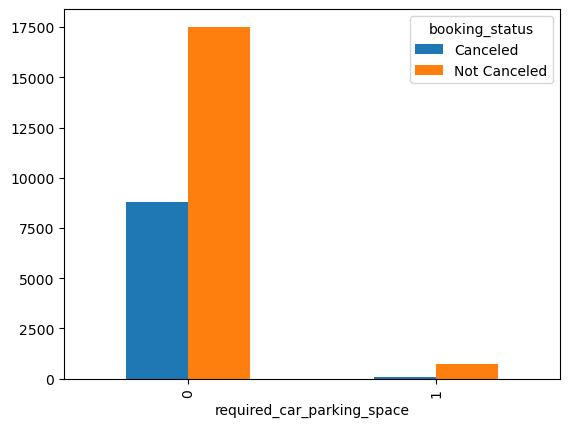

In [36]:
# category columns vs target variable 
t=1
rows=3
cols=2
plt.figure(figsize=(10,10))
for i in cat_cols:
    if i!='booking_status':
        pd.crosstab(past_data[i],past_data['booking_status']).plot(kind='bar')
    plt.show()

In [37]:
# lets do chi-square contigency test to make final conclusions
# h0: columns are independent 
# ha: columns are dependent 

for i in cat_cols:
    if i != 'booking_status':
        contingency_table=pd.crosstab(past_data[i],past_data['booking_status'])
        print(f'column : {i}        pvalues : {stats.chi2_contingency(contingency_table)[1]}')
# we reject h0 as p_values are < 0.05.

column : market_segment_type        pvalues : 7.806389643886697e-11
column : no_of_special_requests        pvalues : 0.0
column : no_of_adults        pvalues : 1.4411855115006094e-73
column : no_of_weekend_nights        pvalues : 5.324997086476798e-43
column : required_car_parking_space        pvalues : 5.626905783478662e-49


Inferences :
- with the confidence of 95% we can conclude that target variable is dependant on all the columns(categorical)

#### (just for refrence)
- inferential statistics(num vs num)

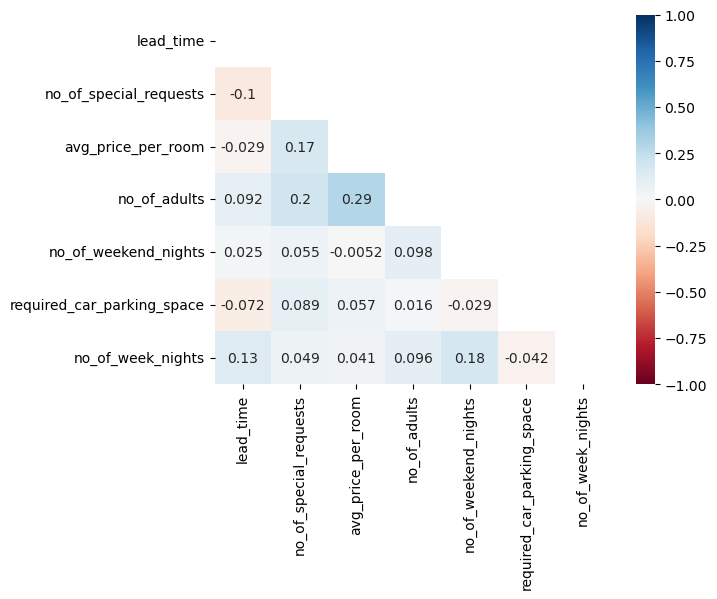

In [38]:
sns.heatmap(data=past_data.corr(numeric_only=True),cmap='RdBu',annot=True,vmin=-1,vmax=1,mask=np.triu(past_data.corr(numeric_only=True)))
plt.show()

In [39]:
past_data['lead_time'].corr(past_data['avg_price_per_room'])

-0.02928918726851987

In [40]:
# parametric test(pearson correlation test)
# assumption : data must be normal

# h0 : variables are independent(no corelation)
# ha : variables are dependent(corelation)

stats.pearsonr(past_data['lead_time'],past_data['avg_price_per_room'])

PearsonRResult(statistic=-0.02928918726851988, pvalue=1.4227003552821461e-06)

In [41]:
# non-parametric test(spearman correlation test)

# h0 : variables are independent(no corelation)
# ha : variables are dependent(corelation)

stats.spearmanr(past_data['lead_time'],past_data['avg_price_per_room'])

# with confidence level of 95% we can say that
# lead_time and avg_price_per_room are correlated

SignificanceResult(statistic=0.00683549727618094, pvalue=0.26055481328066965)

## Data Preprocessing

In [42]:
# check for duplicates:
past_data.duplicated().sum()

# although it shows duplicates but each row has its own booking_id, so we assumes there are no duplicates

8438

In [43]:
# check for missing values
past_data.isna().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [44]:
new_data.isna().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

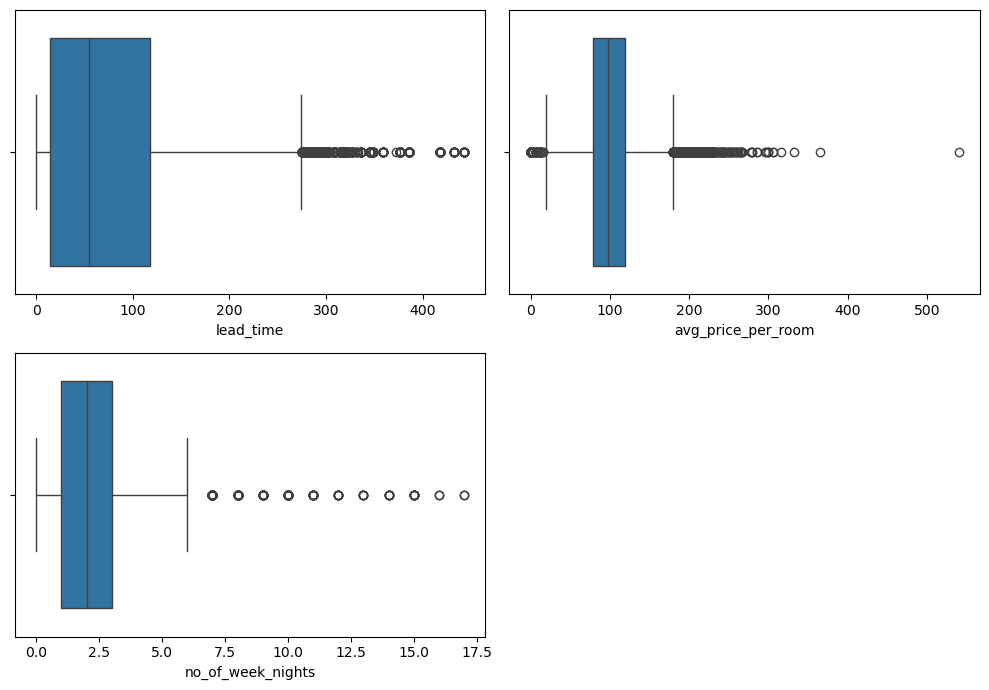

In [45]:
# check for outliers

t=1
rows=2
cols=2
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(rows,cols,t)
    sns.boxplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

In [46]:
past_data[past_data['avg_price_per_room']>400].count()

lead_time                     1
market_segment_type           1
no_of_special_requests        1
avg_price_per_room            1
no_of_adults                  1
no_of_weekend_nights          1
arrival_date                  1
required_car_parking_space    1
no_of_week_nights             1
booking_status                1
dtype: int64

In [47]:
past_data[past_data['avg_price_per_room']>400].index

Index(['INNHG_119173'], dtype='object', name='booking_id')

In [48]:
# for now lets treat the extreme outlier in the avg_price_per_room

past_data.drop(index=past_data[past_data['avg_price_per_room']>400].index,inplace=True)

In [49]:
past_data[past_data['avg_price_per_room']>400].index

Index([], dtype='object', name='booking_id')

In [50]:
# split data i train and test before we do any transformation
y_train=past_data['booking_status'].map({'Not Canceled':0,'Canceled':1})
x_train=past_data.drop(columns='booking_status')

y_test=new_data['booking_status'].map({'Not Canceled':0,'Canceled':1})
x_test=new_data.drop(columns=['booking_status'])

In [51]:
x_test.shape,x_train.shape,y_test.shape,y_train.shape

((3583, 9), (27092, 9), (3583,), (27092,))

#### feature encoding

In [52]:
x_train.dtypes

lead_time                       int64
market_segment_type            object
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
arrival_date                   object
required_car_parking_space      int64
no_of_week_nights               int64
dtype: object

In [53]:
x_train['market_segment_type'].unique()

array(['Online', 'Offline'], dtype=object)

In [54]:
x_train['market_segment_type']=x_train['market_segment_type'].map({'Online':1,'Offline':0})
x_test['market_segment_type']=x_test['market_segment_type'].map({'Online':1,'Offline':0})

In [55]:
x_train['market_segment_type'].unique(),x_test['market_segment_type'].unique()

(array([1, 0], dtype=int64), array([1, 0], dtype=int64))

#### feature Engineering

In [56]:
x_train['arrival_date']=pd.to_datetime(x_train['arrival_date'])
x_test['arrival_date']=pd.to_datetime(x_test['arrival_date'])

In [57]:
x_train.dtypes

lead_time                              int64
market_segment_type                    int64
no_of_special_requests                 int64
avg_price_per_room                   float64
no_of_adults                           int64
no_of_weekend_nights                   int64
arrival_date                  datetime64[ns]
required_car_parking_space             int64
no_of_week_nights                      int64
dtype: object

In [58]:
x_test.dtypes

lead_time                              int64
market_segment_type                    int64
no_of_special_requests                 int64
avg_price_per_room                   float64
no_of_adults                           int64
no_of_weekend_nights                   int64
arrival_date                  datetime64[ns]
required_car_parking_space             int64
no_of_week_nights                      int64
dtype: object

In [59]:
x_train['arrival_month']=x_train['arrival_date'].dt.month
x_train['arrival_day']=x_train['arrival_date'].dt.day
x_train['arrival_weekday']=x_train['arrival_date'].dt.weekday

In [60]:
x_test['arrival_month']=x_test['arrival_date'].dt.month
x_test['arrival_day']=x_test['arrival_date'].dt.day
x_test['arrival_weekday']=x_test['arrival_date'].dt.weekday

In [61]:
x_train.drop(columns='arrival_date',inplace=True)
x_test.drop(columns='arrival_date',inplace=True)

In [62]:
x_train.columns,x_test.columns

(Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
        'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
        'required_car_parking_space', 'no_of_week_nights', 'arrival_month',
        'arrival_day', 'arrival_weekday'],
       dtype='object'),
 Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
        'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
        'required_car_parking_space', 'no_of_week_nights', 'arrival_month',
        'arrival_day', 'arrival_weekday'],
       dtype='object'))

#### Feature transformation

In [63]:
# lets use Yeo-jhonson transformation on numeric columns 
# this way the mdel will fit better and effect of outliers will also be reduced

pt=PowerTransformer(standardize=False)

x_train[['lead_time', 'avg_price_per_room']]=pt.fit_transform(x_train[['lead_time', 'avg_price_per_room']])
x_test[['lead_time', 'avg_price_per_room']]=pt.transform(x_test[['lead_time', 'avg_price_per_room']])

In [64]:
x_train[['lead_time', 'avg_price_per_room']]

,lead_time,avg_price_per_room
booking_id,,
INNHG_101034,0.000000,56.295048
INNHG_101035,5.761007,79.293092
INNHG_101036,4.968824,48.374328
INNHG_101037,4.877215,56.100970
INNHG_101038,6.512656,92.797741
...,...,...
INNHG_128122,9.140224,56.277408
INNHG_128123,3.457688,87.052496
INNHG_128124,5.830439,75.234221


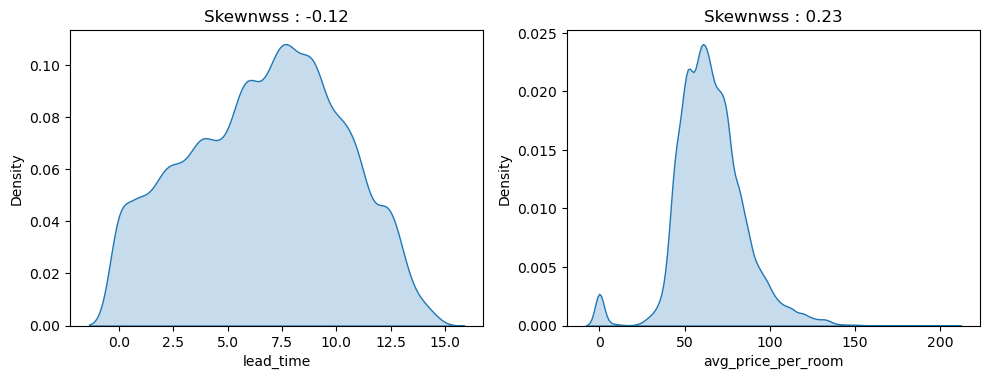

In [65]:
t=1
rows=2
cols=2
plt.figure(figsize=(10,7))
for i in ['lead_time', 'avg_price_per_room']:
    plt.subplot(rows,cols,t)
    plt.title(f'Skewnwss : {round(x_train[i].skew(),2)}')
    sns.kdeplot(data=x_train,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()

## Modelling

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier)
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,cohen_kappa_score,confusion_matrix,
                             classification_report,roc_auc_score,roc_curve)

from sklearn.model_selection import GridSearchCV

In [67]:
# create a function to validate a model

m=[] # model
accu=[] # accuracy
rec=[] # recall
pre=[] # precision
f1=[] # f1 score
kap=[] # cohen-kappa

def model_validation(model,xtrain,ytrain,xtest,ytest):
    mod=model
    mod.fit(xtrain,ytrain)
    pred_s=mod.predict_proba(xtest)[:,1]
    pred_h=mod.predict(xtest)

    print('confusion_matrix :','\n',confusion_matrix(ytest,pred_h))
    print('classification_report :','\n',classification_report(ytest,pred_h))
    
    fpr,tpr,thres=roc_curve(ytest,pred_s)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],color='red',ls='--')
    plt.title(f'ROC AUC : {round(roc_auc_score(ytest,pred_s),4)}')
    plt.show()

    response=input('Do you want to save this model? Y?N :')
    if response.lower()=='y':
        global score_card
        m.append(str(model))
        accu.append(accuracy_score(ytest,pred_h))
        rec.append(recall_score(ytest,pred_h))
        pre.append(precision_score(ytest,pred_h))
        f1.append(f1_score(ytest,pred_h))
        kap.append(cohen_kappa_score(ytest,pred_h))

        score_card=pd.DataFrame({'Model':m,'Accuracy':accu,'Recall':rec,'Precision':pre,'F1-score':f1,'Cohen-Kappa':kap})
    else:
        return

### Logistic Regression

confusion_matrix : 
 [[1638  745]
 [ 261  939]]
classification_report : 
               precision    recall  f1-score   support

           0       0.86      0.69      0.77      2383
           1       0.56      0.78      0.65      1200

    accuracy                           0.72      3583
   macro avg       0.71      0.73      0.71      3583
weighted avg       0.76      0.72      0.73      3583



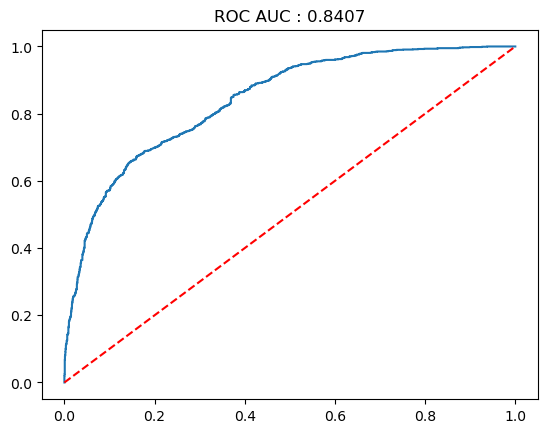

In [68]:
model_validation(LogisticRegression(class_weight='balanced'),x_train,y_train,x_test,y_test)

In [69]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.71923,0.7825,0.557601,0.651179,0.427109


### Navie Bayes

confusion_matrix : 
 [[1782  601]
 [ 445  755]]
classification_report : 
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      2383
           1       0.56      0.63      0.59      1200

    accuracy                           0.71      3583
   macro avg       0.68      0.69      0.68      3583
weighted avg       0.72      0.71      0.71      3583



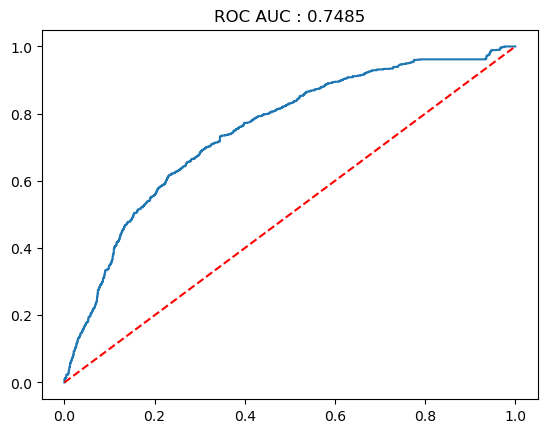

In [74]:
model_validation(GaussianNB(),x_train,y_train,x_test,y_test)

confusion_matrix : 
 [[2281  102]
 [ 911  289]]
classification_report : 
               precision    recall  f1-score   support

           0       0.71      0.96      0.82      2383
           1       0.74      0.24      0.36      1200

    accuracy                           0.72      3583
   macro avg       0.73      0.60      0.59      3583
weighted avg       0.72      0.72      0.67      3583



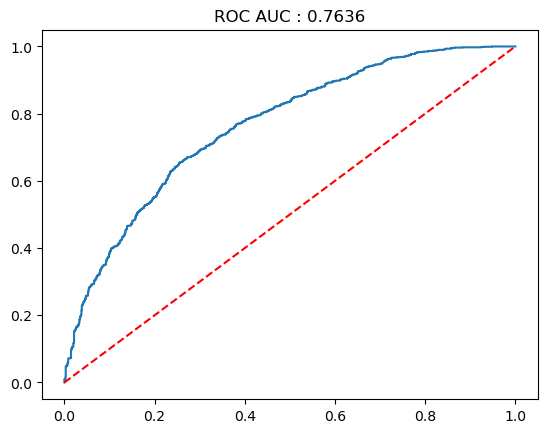

In [75]:
model_validation(MultinomialNB(),x_train,y_train,x_test,y_test)

confusion_matrix : 
 [[2301   82]
 [1138   62]]
classification_report : 
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      2383
           1       0.43      0.05      0.09      1200

    accuracy                           0.66      3583
   macro avg       0.55      0.51      0.44      3583
weighted avg       0.59      0.66      0.56      3583



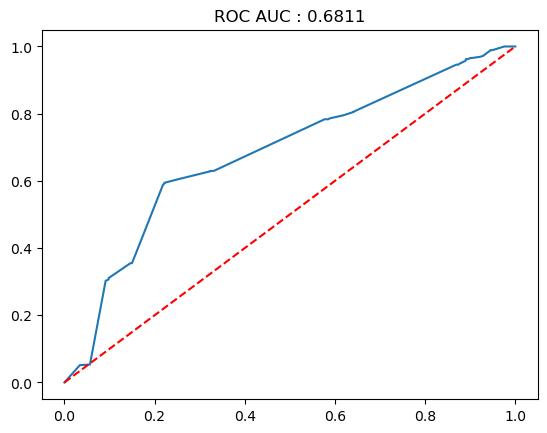

In [76]:
model_validation(BernoulliNB(),x_train,y_train,x_test,y_test)

In [77]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079


### Decision Tree

confusion_matrix : 
 [[2158  225]
 [ 355  845]]
classification_report : 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      2383
           1       0.79      0.70      0.74      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.80      0.81      3583
weighted avg       0.84      0.84      0.84      3583



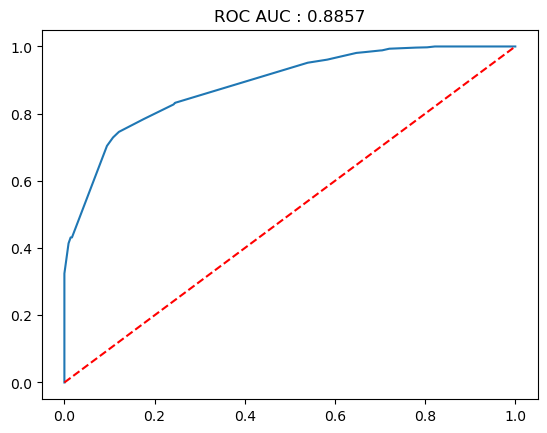

In [78]:
model_validation(DecisionTreeClassifier(max_depth=5),x_train,y_train,x_test,y_test)

In [79]:
grid={'max_depth':[4,5,6,7,8,9],
      'max_leaf_nodes':[13,15,17,19,21]}

gscv=GridSearchCV(estimator=DecisionTreeClassifier(),cv=5,scoring='roc_auc',verbose=1,param_grid=grid)

In [80]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [13, 15, 17, 19, 21]},
             scoring='roc_auc', verbose=1)

In [81]:
gscv.best_params_

{'max_depth': 6, 'max_leaf_nodes': 21}

confusion_matrix : 
 [[2099  284]
 [ 318  882]]
classification_report : 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      2383
           1       0.76      0.73      0.75      1200

    accuracy                           0.83      3583
   macro avg       0.81      0.81      0.81      3583
weighted avg       0.83      0.83      0.83      3583



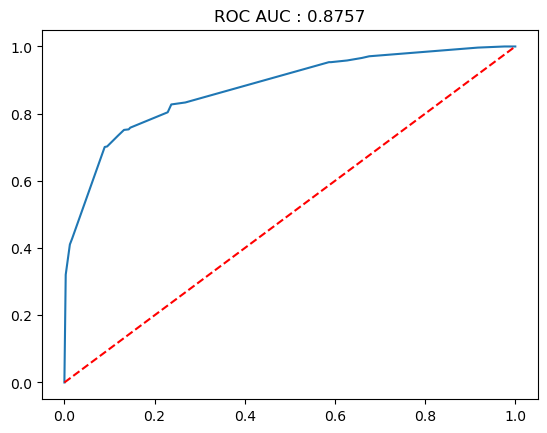

In [82]:
model_validation(DecisionTreeClassifier(**gscv.best_params_),x_train,y_train,x_test,y_test)

### Random Forest Classifier

In [85]:
grid={'min_samples_split':[500,800,1100],
      'n_estimators':[70,100,130]}

gscv=GridSearchCV(estimator=RandomForestClassifier(),cv=5,scoring='roc_auc',verbose=1,param_grid=grid)

In [86]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': [500, 800, 1100],
                         'n_estimators': [70, 100, 130]},
             scoring='roc_auc', verbose=1)

In [87]:
gscv.best_params_

{'min_samples_split': 800, 'n_estimators': 70}

In [88]:
gscv.best_score_

0.812174514864099

confusion_matrix : 
 [[2250  133]
 [ 551  649]]
classification_report : 
               precision    recall  f1-score   support

           0       0.80      0.94      0.87      2383
           1       0.83      0.54      0.65      1200

    accuracy                           0.81      3583
   macro avg       0.82      0.74      0.76      3583
weighted avg       0.81      0.81      0.80      3583



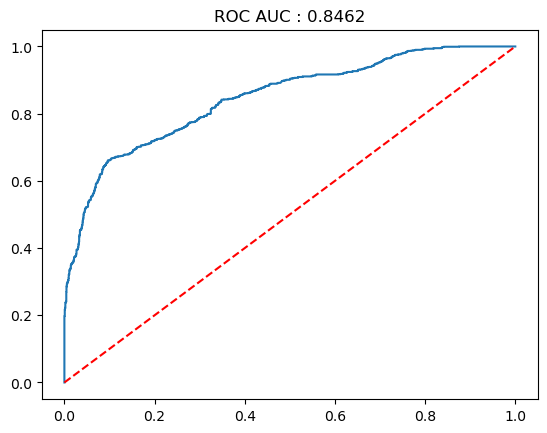

In [89]:
model_validation(RandomForestClassifier(**gscv.best_params_,max_depth=6),x_train,y_train,x_test,y_test)

In [90]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079
4,DecisionTreeClassifier(max_depth=5),0.838124,0.704167,0.789720,0.744493,0.626597
5,"DecisionTreeClassifier(max_depth=6, max_leaf_n...",0.831984,0.735000,0.756432,0.745562,0.620184
6,"RandomForestClassifier(max_depth=6, min_sample...",0.809099,0.540833,0.829923,0.654894,0.530926


# Ada Boost

In [123]:
grid={'n_estimators':[100,150,200]}

gscv=GridSearchCV(estimator=AdaBoostClassifier(learning_rate=0.4),cv=5,scoring='roc_auc',verbose=1,param_grid=grid)

In [124]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(learning_rate=0.4),
             param_grid={'n_estimators': [100, 150, 200]}, scoring='roc_auc',
             verbose=1)

In [125]:
gscv.best_params_

{'n_estimators': 100}

In [126]:
gscv.best_score_

0.7651224824676489

confusion_matrix : 
 [[2013  370]
 [ 385  815]]
classification_report : 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2383
           1       0.69      0.68      0.68      1200

    accuracy                           0.79      3583
   macro avg       0.76      0.76      0.76      3583
weighted avg       0.79      0.79      0.79      3583



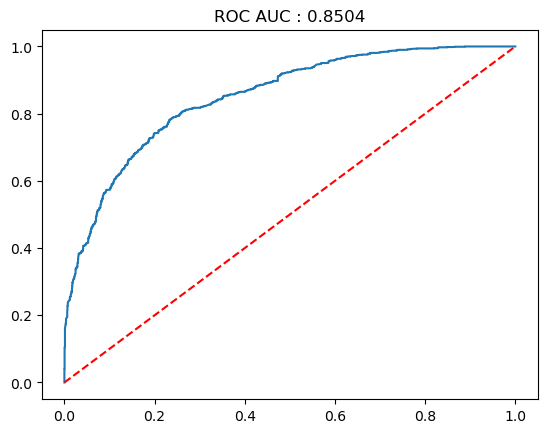

In [127]:
model_validation(AdaBoostClassifier(**gscv.best_params_,learning_rate=0.4),x_train,y_train,x_test,y_test)

### XGBoost

In [175]:
grid={'max_depth':[4,5,6]}

gscv=GridSearchCV(estimator=XGBClassifier(n_estimators=70,learning_rate=0.1),cv=5,scoring='roc_auc',verbose=1,param_grid=grid)

In [176]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=70,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [4, 5, 6]}, scoring='roc_auc', verbose=1)

In [177]:
gscv.best_params_

{'max_depth': 4}

In [178]:
gscv.best_score_

0.7559401718619823

confusion_matrix : 
 [[2185  198]
 [ 360  840]]
classification_report : 
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      2383
           1       0.81      0.70      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.83      0.81      0.82      3583
weighted avg       0.84      0.84      0.84      3583



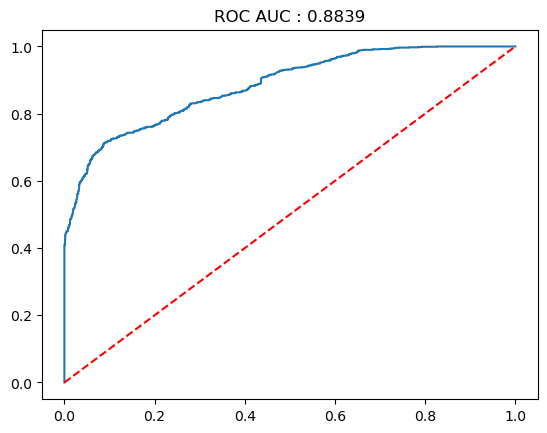

In [180]:
model_validation(XGBClassifier(**gscv.best_params_,n_estimators=70,learning_rate=0.1),x_train,y_train,x_test,y_test)

In [181]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079
4,DecisionTreeClassifier(max_depth=5),0.838124,0.704167,0.789720,0.744493,0.626597
5,"DecisionTreeClassifier(max_depth=6, max_leaf_n...",0.831984,0.735000,0.756432,0.745562,0.620184
6,"RandomForestClassifier(max_depth=6, min_sample...",0.809099,0.540833,0.829923,0.654894,0.530926
7,"AdaBoostClassifier(learning_rate=0.4, n_estima...",0.789283,0.679167,0.687764,0.683438,0.525531
8,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.780000,0.602704,0.679985,0.485624
9,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.754167,0.606975,0.672612,0.479402


### Gradient Boost

In [193]:
grid={'n_estimators':[70,100,150]}

gscv=GridSearchCV(estimator=GradientBoostingClassifier(),cv=5,scoring='roc_auc',verbose=1,param_grid=grid)

In [194]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'n_estimators': [70, 100, 150]}, scoring='roc_auc',
             verbose=1)

In [195]:
gscv.best_params_

{'n_estimators': 70}

In [196]:
gscv.best_score_

0.7962805600077447

confusion_matrix : 
 [[2163  220]
 [ 349  851]]
classification_report : 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      2383
           1       0.79      0.71      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.83      0.81      0.82      3583
weighted avg       0.84      0.84      0.84      3583



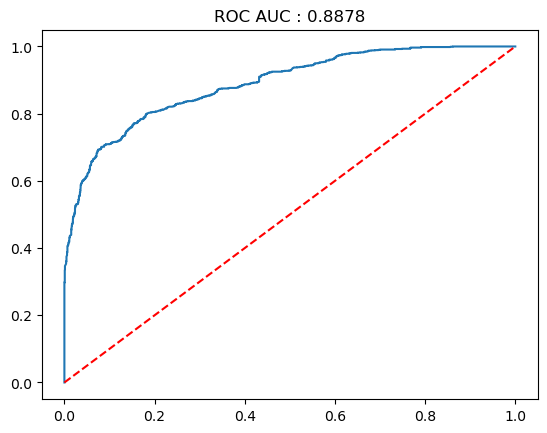

In [197]:
model_validation(GradientBoostingClassifier(**gscv.best_params_),x_train,y_train,x_test,y_test)

### Lets check for the variance in DT and XGB

In [221]:
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold

In [185]:
scores=cross_val_score(estimator=DecisionTreeClassifier(max_depth=6),X=x_train,y=y_train,cv=6,scoring='f1')
scores

array([0.75459931, 0.64712451, 0.35772965, 0.35791645, 0.6961039 ,
       0.49667716])

In [186]:
scores=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=4),X=x_train,y=y_train,cv=6,scoring='f1')
scores

array([0.7009727 , 0.49189863, 0.19402074, 0.32987439, 0.68498059,
       0.7420999 ])

In [230]:
scores=cross_val_score(estimator=DecisionTreeClassifier(max_depth=5),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.68459435, 0.68278805, 0.66382979, 0.67808837, 0.69891501,
       0.71472527, 0.66888046])

In [231]:
scores=cross_val_score(estimator=DecisionTreeClassifier(max_depth=6),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.72781065, 0.73125822, 0.72860847, 0.70113935, 0.74052718,
       0.74752688, 0.71135781])

In [252]:
scores_xgb1=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=7),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores_xgb1
# best model

array([0.79884106, 0.79879622, 0.80559085, 0.80501618, 0.81466395,
       0.83285889, 0.79077711])

In [253]:
scores_xgb2=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=7),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores_xgb2

array([0.79415449, 0.7888651 , 0.79932261, 0.7960928 , 0.8018055 ,
       0.82464066, 0.7743612 ])

### Voting classifier

In [202]:
base_model=[('DT1',DecisionTreeClassifier(max_depth=5)),
            ('DT2',DecisionTreeClassifier(max_depth=6)),
            ('XGB1',XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=5)),
            ('XGB2',XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=5))]

confusion_matrix : 
 [[2173  210]
 [ 334  866]]
classification_report : 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2383
           1       0.80      0.72      0.76      1200

    accuracy                           0.85      3583
   macro avg       0.84      0.82      0.82      3583
weighted avg       0.85      0.85      0.85      3583



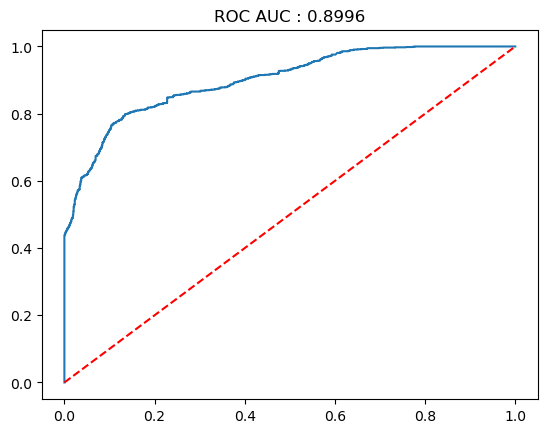

In [201]:
model_validation(VotingClassifier(estimators=base_model,voting='soft'),x_train,y_train,x_test,y_test)

In [203]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079
4,DecisionTreeClassifier(max_depth=5),0.838124,0.704167,0.789720,0.744493,0.626597
5,"DecisionTreeClassifier(max_depth=6, max_leaf_n...",0.831984,0.735000,0.756432,0.745562,0.620184
6,"RandomForestClassifier(max_depth=6, min_sample...",0.809099,0.540833,0.829923,0.654894,0.530926
7,"AdaBoostClassifier(learning_rate=0.4, n_estima...",0.789283,0.679167,0.687764,0.683438,0.525531
8,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.780000,0.602704,0.679985,0.485624
9,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.754167,0.606975,0.672612,0.479402


### Stacking

confusion_matrix : 
 [[2147  236]
 [ 352  848]]
classification_report : 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      2383
           1       0.78      0.71      0.74      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.80      0.81      3583
weighted avg       0.83      0.84      0.83      3583



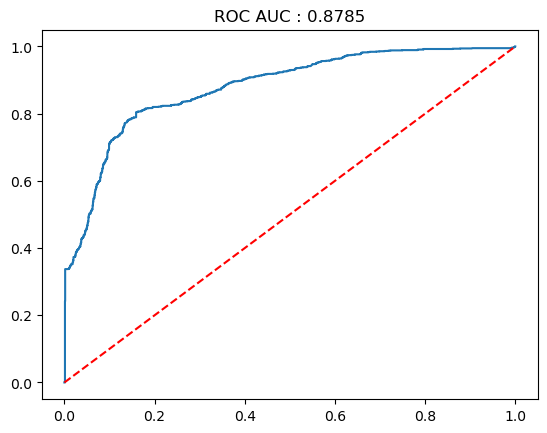

In [206]:
model_validation(StackingClassifier(estimators=base_model,stack_method='predict_proba'),x_train,y_train,x_test,y_test)

In [207]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079
4,DecisionTreeClassifier(max_depth=5),0.838124,0.704167,0.789720,0.744493,0.626597
5,"DecisionTreeClassifier(max_depth=6, max_leaf_n...",0.831984,0.735000,0.756432,0.745562,0.620184
6,"RandomForestClassifier(max_depth=6, min_sample...",0.809099,0.540833,0.829923,0.654894,0.530926
7,"AdaBoostClassifier(learning_rate=0.4, n_estima...",0.789283,0.679167,0.687764,0.683438,0.525531
8,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.780000,0.602704,0.679985,0.485624
9,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.754167,0.606975,0.672612,0.479402


In [209]:
scores=cross_val_score(estimator=StackingClassifier(estimators=base_model,stack_method='predict_proba'),X=x_train,y=y_train,cv=6,scoring='roc_auc')
scores

array([0.82344619, 0.7471801 , 0.40288434, 0.74647402, 0.75964394,
       0.59196391])

confusion_matrix : 
 [[2153  230]
 [ 347  853]]
classification_report : 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      2383
           1       0.79      0.71      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.81      0.81      3583
weighted avg       0.84      0.84      0.84      3583



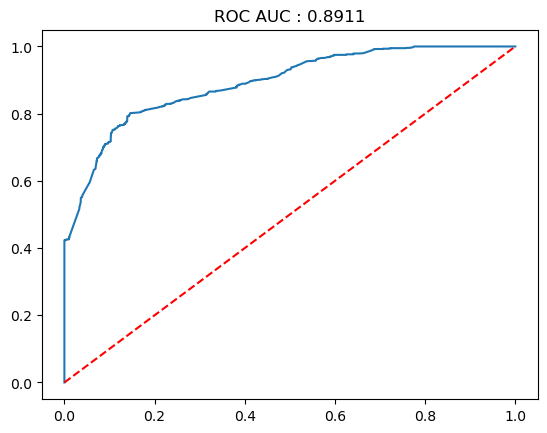

In [210]:
# lets try and tune random forest

model_validation(RandomForestClassifier(n_estimators=100,max_features=None,max_depth=5),x_train,y_train,x_test,y_test)

In [220]:
scores=cross_val_score(estimator=RandomForestClassifier(n_estimators=100,max_features=None,max_depth=6,class_weight='balanced'),\
                       X=x_train,y=y_train,cv=7,scoring='f1')
scores

array([0.72154341, 0.74947953, 0.67016886, 0.23309723, 0.62580185,
       0.72098437, 0.680067  ])

In [224]:
scores=cross_val_score(estimator=RandomForestClassifier(n_estimators=100,max_features=None,max_depth=6,class_weight='balanced'),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.75235582, 0.75325701, 0.75360062, 0.75492748, 0.75184638,
       0.7808321 , 0.74407767])

In [227]:
scores=cross_val_score(estimator=RandomForestClassifier(n_estimators=100,max_features=None,max_depth=6,class_weight='balanced'),\
                       X=x_train,y=y_train,cv=StratifiedKFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.7578304 , 0.77179682, 0.76888556, 0.74071237, 0.75937855,
       0.77078652, 0.74662669])

In [234]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079
4,DecisionTreeClassifier(max_depth=5),0.838124,0.704167,0.789720,0.744493,0.626597
5,"DecisionTreeClassifier(max_depth=6, max_leaf_n...",0.831984,0.735000,0.756432,0.745562,0.620184
6,"RandomForestClassifier(max_depth=6, min_sample...",0.809099,0.540833,0.829923,0.654894,0.530926
7,"AdaBoostClassifier(learning_rate=0.4, n_estima...",0.789283,0.679167,0.687764,0.683438,0.525531
8,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.780000,0.602704,0.679985,0.485624
9,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.754167,0.606975,0.672612,0.479402


In [236]:
score_card['Model'][5]

'DecisionTreeClassifier(max_depth=6, max_leaf_nodes=21)'

In [237]:
scores=cross_val_score(estimator=DecisionTreeClassifier(max_depth=6, max_leaf_nodes=21),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.71391753, 0.72110665, 0.7110719 , 0.67663043, 0.72336842,
       0.72886553, 0.70448549])

In [261]:
scores_xgb1=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=10),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores_xgb1
# best model

array([0.82654723, 0.8202765 , 0.8320802 , 0.82451923, 0.83252427,
       0.85140562, 0.82557155])

In [262]:
scores_xgb2=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=10),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores_xgb2

array([0.81432688, 0.81400253, 0.82042696, 0.8159164 , 0.82333874,
       0.83353584, 0.80153978])

In [263]:
scores_xgb1.mean()

0.8304178005865153

In [264]:
scores_xgb2.mean()

0.8175838753637316

In [265]:
scores_xgb1.std()/scores_xgb1.mean()

0.01136777965276636

In [266]:
scores_xgb2.std()/scores_xgb2.mean()

0.011126750200061156

In [258]:
scores_vot=cross_val_score(estimator=VotingClassifier(estimators=base_model,voting='soft'),\
                       X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores_vot

array([0.74682991, 0.74900044, 0.74544647, 0.74726201, 0.76923077,
       0.76293103, 0.73698384])

In [259]:
scores_vot.mean()

0.7510977816341501

In [260]:
scores_vot.std()/scores_vot.mean()

0.01366394719395202

## lets finalize xgb1 and further fine tune it

In [283]:
grid={'n_estimators':[70,80],
      'learning_rate':[0.1,0.7,0.5],
      'max_depth':[7,8,9,10]}

In [284]:
gscv=GridSearchCV(estimator=XGBClassifier(),cv=KFold(n_splits=5,shuffle=True,random_state=2),scoring='f1'\
                  ,verbose=1,param_grid=grid)

In [285]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.7, 0.5],
                         'max_depth': [7, 8, 9, 10], 'n_estimators': [70, 80]},
             scoring='f1', verbose=1)

In [286]:
gscv.best_params_

{'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 80}

In [287]:
gscv.best_score_

0.8388311726059217

confusion_matrix : 
 [[1805  578]
 [ 272  928]]
classification_report : 
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      2383
           1       0.62      0.77      0.69      1200

    accuracy                           0.76      3583
   macro avg       0.74      0.77      0.75      3583
weighted avg       0.78      0.76      0.77      3583



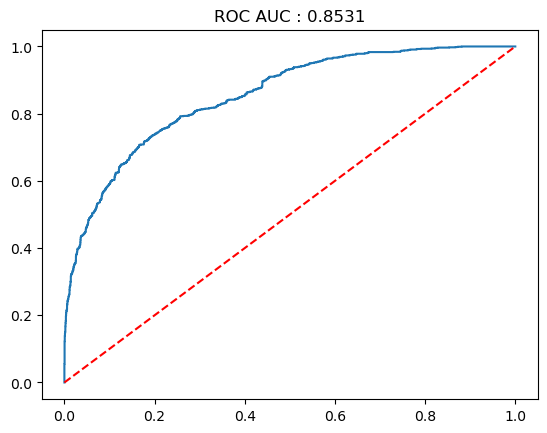

In [288]:
model_validation(XGBClassifier(**gscv.best_params_),x_train,y_train,x_test,y_test)

In [289]:
score_card

,Model,Accuracy,Recall,Precision,F1-score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.719230,0.782500,0.557601,0.651179,0.427109
1,GaussianNB(),0.708066,0.629167,0.556785,0.590767,0.365180
2,MultinomialNB(),0.717276,0.240833,0.739130,0.363294,0.237828
3,BernoulliNB(),0.659503,0.051667,0.430556,0.092262,0.022079
4,DecisionTreeClassifier(max_depth=5),0.838124,0.704167,0.789720,0.744493,0.626597
5,"DecisionTreeClassifier(max_depth=6, max_leaf_n...",0.831984,0.735000,0.756432,0.745562,0.620184
6,"RandomForestClassifier(max_depth=6, min_sample...",0.809099,0.540833,0.829923,0.654894,0.530926
7,"AdaBoostClassifier(learning_rate=0.4, n_estima...",0.789283,0.679167,0.687764,0.683438,0.525531
8,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.780000,0.602704,0.679985,0.485624
9,"XGBClassifier(base_score=None, booster=None, c...",0.754117,0.754167,0.606975,0.672612,0.479402


## Deployment

In [290]:
final_model=XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=10)
final_model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Feature importances

In [294]:
x_test.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_month,arrival_day,arrival_weekday
booking_id,,,,,,,,,,,
INNHG_128127,1.986021,1,1,66.738732,1,0,1,1,7,1,4
INNHG_128128,10.033278,1,2,67.140953,2,2,0,2,7,1,4
INNHG_128129,6.339587,1,1,80.303437,2,1,1,2,7,1,4
INNHG_128130,9.985257,0,0,49.015671,2,0,0,1,7,1,4
INNHG_128131,8.275467,0,1,69.427566,2,1,0,2,7,1,4


In [304]:
pd.DataFrame(final_model.feature_importances_,index=x_train.columns).sort_values(by=0,ascending=False)

,0
market_segment_type,0.217390
no_of_special_requests,0.188318
lead_time,0.140297
required_car_parking_space,0.121112
no_of_adults,0.080884
avg_price_per_room,0.062231
arrival_month,0.057556
no_of_weekend_nights,0.048064
no_of_week_nights,0.032721
arrival_day,0.028166


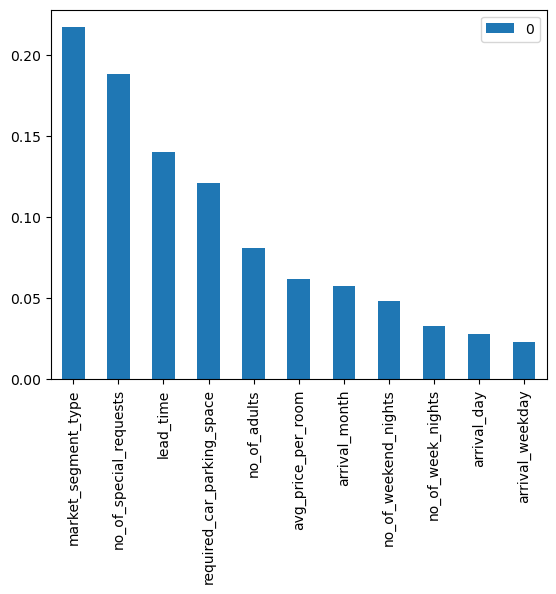

In [306]:
pd.DataFrame(final_model.feature_importances_,index=x_train.columns)\
    .sort_values(by=0,ascending=False).plot(kind='bar')
plt.show()

In [299]:
lt=7
mst=1
spcl=0
price=150
adults=2
weekendnight=2
park=0
wk=0
month=11
day=10
weekd=5

In [300]:
tran_data=pt.transform([[lt,price]])[0]
lt_t=tran_data[0]
price_t=tran_data[1]

In [301]:
lt_t,price_t

(2.735551785137862, 93.12772243246981)

In [302]:
final_model.predict([[lt_t,mst,spcl,price_t,adults,weekendnight,park,wk,month,day,weekd]])

array([0])

In [303]:
final_model.predict_proba([[lt_t,mst,spcl,price_t,adults,weekendnight,park,wk,month,day,weekd]])

array([[0.70764303, 0.29235697]], dtype=float32)

In [307]:
# lets save fitted model and transformer instance

import pickle

In [309]:
with open('final_model_xgb.pkl','wb') as file :
    pickle.dump(final_model,file)

In [310]:
with open('transformer.pkl','wb') as file :
    pickle.dump(pt,file)

In [ ]:
# %%writefile app.py --> use this when you have to write .py file i jupyter notebook